In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

2025-10-28 04:31:02.503302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761625862.744328      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761625862.812096      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

I0000 00:00:1761625875.694872      19 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


True

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')

In [4]:
train_enc_df = train_df.copy()
encoder = LabelEncoder()
train_enc_df["time_of_day"] = encoder.fit_transform(train_df["time_of_day"])
train_enc_df["weather"] = encoder.fit_transform(train_df["weather"])
train_enc_df["lighting"] = encoder.fit_transform(train_df["lighting"])
train_enc_df["road_type"] = encoder.fit_transform(train_df["road_type"])

In [5]:
train_enc_df

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,2,2,0.06,35,0,2,False,True,0,False,True,1,0.13
1,1,2,4,0.99,35,0,0,True,False,1,True,True,0,0.35
2,2,1,4,0.63,70,1,0,False,True,2,True,False,2,0.30
3,3,0,4,0.07,35,1,2,True,True,2,False,False,1,0.21
4,4,1,1,0.58,60,0,1,False,False,1,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,517749,0,4,0.10,70,0,1,True,True,0,False,False,2,0.32
517750,517750,1,4,0.47,35,0,2,True,True,2,False,False,1,0.26
517751,517751,2,4,0.62,25,0,1,False,False,0,False,True,0,0.19
517752,517752,0,3,0.63,25,2,0,True,False,0,True,True,3,0.51


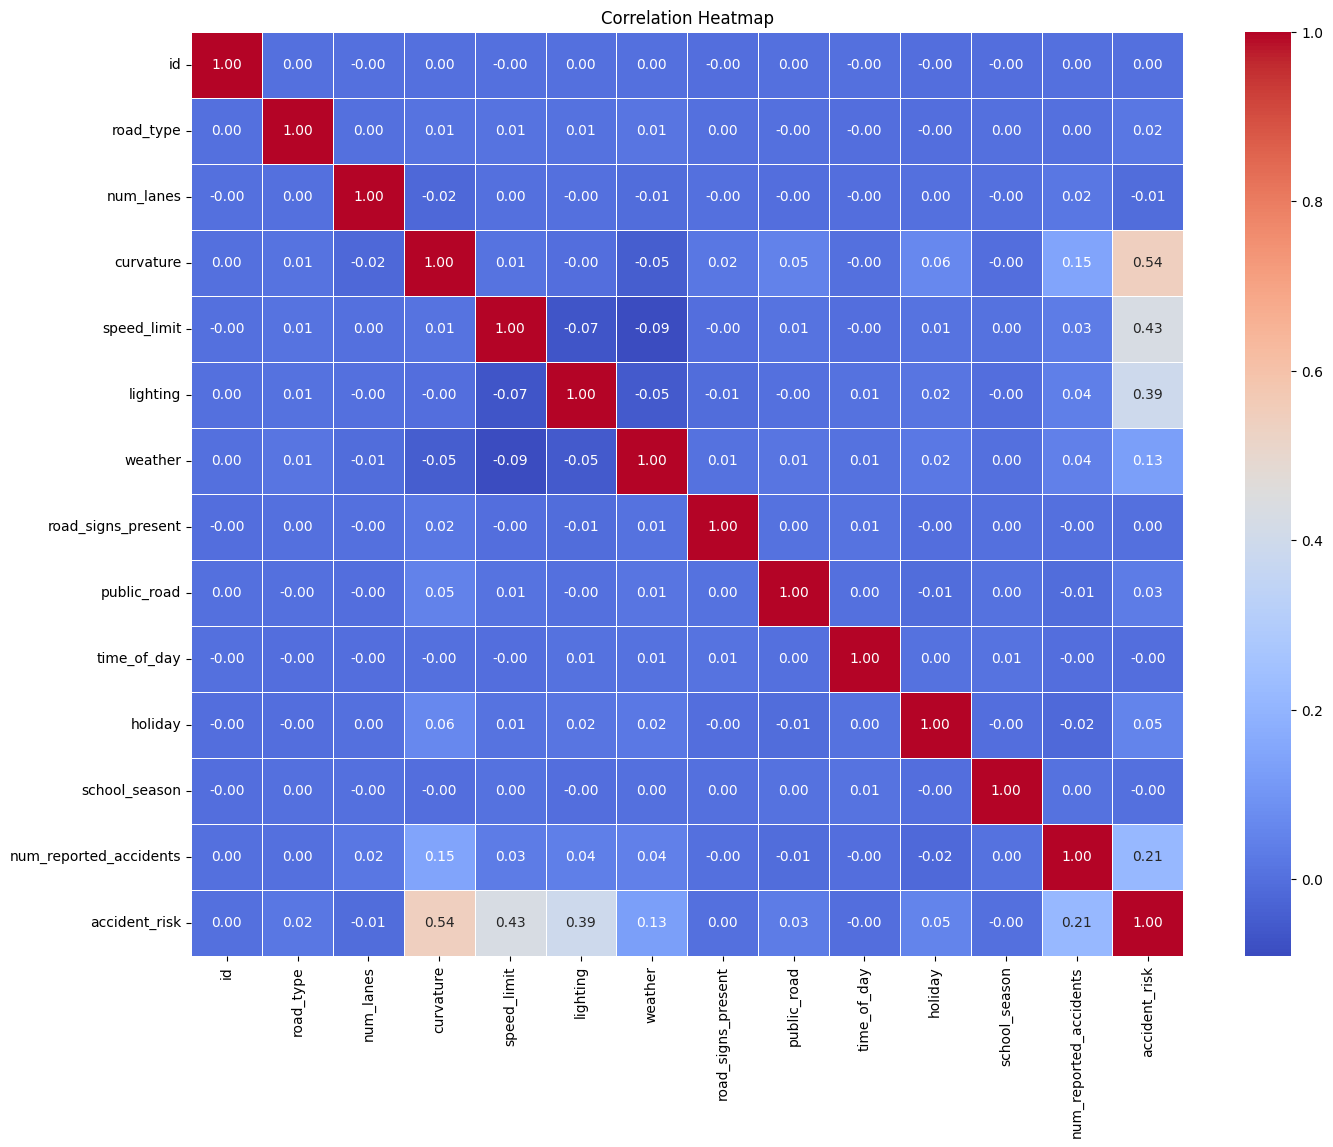

In [6]:
# train_enc_df = pd.get_dummies(train_df)
train_mat = train_enc_df.corr()

plt.figure(figsize=(16,12))
sns.heatmap(train_mat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [7]:
# X = train_enc_df[["curvature", "speed_limit", "lighting", "weather"]]
X = train_enc_df.iloc[:, 1:-1]
Y = train_enc_df["accident_risk"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.4, shuffle=True)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((310652, 12), (310652,), (207102, 12), (207102,))

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(12,)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["mae"])

I0000 00:00:1761625878.529764      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


I0000 00:00:1761625882.167541      61 service.cc:148] XLA service 0x7a6774005aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761625882.168166      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761625882.483673      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  59/9708 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 1.8998 - mae: 1.8998

I0000 00:00:1761625883.325926      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9708/9708 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.1041 - mae: 0.1041 - val_loss: 0.0504 - val_mae: 0.0504
Epoch 2/10
9708/9708 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0497 - mae: 0.0497 - val_loss: 0.0466 - val_mae: 0.0466
Epoch 3/10
9708/9708 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0472 - mae: 0.0472 - val_loss: 0.0456 - val_mae: 0.0456
Epoch 4/10
9708/9708 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0463 - mae: 0.0463 - val_loss: 0.0452 - val_mae: 0.0452
Epoch 5/10
9708/9708 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0460 - mae: 0.0460 - val_loss: 0.0456 - val_mae: 0.0456
Epoch 6/10
9708/9708 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0456 - mae: 0.0456 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 7/10
9708/9708 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0454 - mae: 0.0454 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 8/10
9708/9708 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0453 - mae: 0.0453 - val_loss: 0.0447 - val_mae: 0.0447
Epoch 9/10
9708/9708 ━━━━━━━━━━━━━━━━━━━━ 3

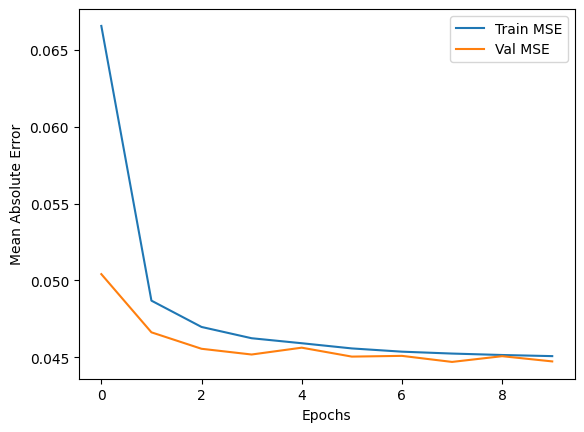

In [11]:
plt.plot(history.history['mae'], label='Train MSE')
plt.plot(history.history['val_mae'], label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [12]:
ytest_pred = model.predict(X_test)

6472/6472 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [13]:
ytest_pred.shape

(207102, 1)

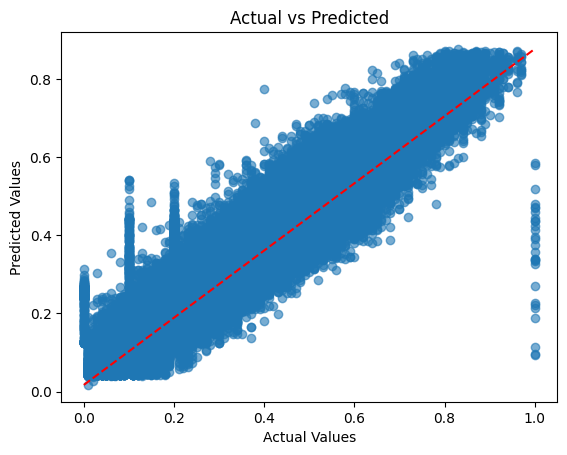

In [14]:
plt.scatter(y_test, ytest_pred, alpha=0.6)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()],
         [ytest_pred.min(), ytest_pred.max()],
         'r--')  # diagonal line
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, ytest_pred)
print(f"MAE : {mae:.4f}")

mse = mean_squared_error(y_test, ytest_pred)
print(f"MAE : {mse:.4f}")

MAE : 0.0447
MAE : 0.0033


In [16]:
test_enc_df = test_df.copy()

test_enc_df["time_of_day"] = encoder.fit_transform(test_df["time_of_day"])
test_enc_df["weather"] = encoder.fit_transform(test_df["weather"])
test_enc_df["lighting"] = encoder.fit_transform(test_df["lighting"])
test_enc_df["road_type"] = encoder.fit_transform(test_df["road_type"])

In [17]:
# submission_pred = model.predict(test_enc_df[["curvature", "speed_limit", "lighting", "weather"]])
submission_pred = model.predict(test_enc_df.iloc[:, 1:])

5394/5394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [18]:
submission_pred[:,0]

array([0.29149812, 0.12663333, 0.1912784 , ..., 0.26277253, 0.12769248,
       0.48215914], dtype=float32)

In [19]:
submission = pd.DataFrame({'id': test_enc_df["id"], 'accident_risk': submission_pred[:,0]})
submission.to_csv('submission.csv', index=False)
display(submission.head())

,id,accident_risk
0,517754,0.291498
1,517755,0.126633
2,517756,0.191278
3,517757,0.325759
4,517758,0.392863
